# Data prep and Compare three models under the default setting (Shortage penalty = 8, and TOTAL_PREPOSITION_STOCK = 220)
We let the surge capacity be 15% of the hostipal capacity

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from IPython.display import display # for display dataframes nicely

# ==========================================
# Load data
# ==========================================

# Read datasets
df_continuous = pd.read_csv("hospital_disaster_continuous_dataset.csv") 
df_uncertainty = pd.read_csv("hospital_uncertainty_sets.csv") 

# a scenario contains demand data for all 3 hospitals (3 rows per scenario)
full_demand = df_continuous.pivot(index="scenario_id", columns="hospital_id", values="demand")

# get the probs of each scenario
scenario_probs = df_continuous.groupby("scenario_id")["scenario_probability"].first()
scenario_probs = scenario_probs / scenario_probs.sum()

hospital_info = (
    df_continuous[[
        "hospital_id", "hospital_name", "capacity_beds", 
        "allocation_cost_per_unit", 
        "surge_cost_per_unit"
    ]]
    .drop_duplicates(subset=["hospital_id"])
    .set_index("hospital_id")
)

hospitals = list(hospital_info.index)
capacity = hospital_info["capacity_beds"].to_dict()
alloc_cost = hospital_info["allocation_cost_per_unit"].to_dict()

# User defined surge capacity rule
surge_capacity = {h: int(capacity[h] * 0.15) for h in hospitals}
surge_cost = hospital_info["surge_cost_per_unit"].to_dict() 

# User defined shortage penalty
SHORTAGE_PENALTY = 8

# Total Preposition Stock
TOTAL_PREPOSITION_STOCK = 220

# ==========================================
# 1. Deterministic LP (Expected Value Method)
# ==========================================
# weighted average demand per hospital
weighted_demand = full_demand.multiply(scenario_probs, axis=0).sum()

lp_model = gp.Model("LP_Deterministic"); lp_model.Params.OutputFlag = 0
x_lp = lp_model.addVars(hospitals, name="alloc", lb=0); y_lp = lp_model.addVars(hospitals, name="surge", lb=0); z_lp = lp_model.addVars(hospitals, name="shortage", lb=0)
lp_model.addConstr(gp.quicksum(x_lp[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK)
for h in hospitals:
    lp_model.addConstr(x_lp[h] <= capacity[h]); lp_model.addConstr(y_lp[h] <= surge_capacity[h])
    lp_model.addConstr(x_lp[h] + y_lp[h] + z_lp[h] >= weighted_demand[h])
lp_model.setObjective(gp.quicksum(alloc_cost[h] * x_lp[h] + surge_cost[h] * y_lp[h] + SHORTAGE_PENALTY * z_lp[h] for h in hospitals), GRB.MINIMIZE)
lp_model.optimize()
lp_plan = {h: x_lp[h].X for h in hospitals}

# ==========================================
# 3. Stochastic SP
# ==========================================
SAMPLE_SIZE = 200; np.random.seed(42) # 200, as lower sampleing will make it even worser than LP (not good samples)
# replace must be true, so the sampling is more representative
sampled_scenario_ids = np.random.choice(
    list(full_demand.index), 
    size=SAMPLE_SIZE, 
    replace=True, 
    p=scenario_probs.values
)

sampled_indices = range(SAMPLE_SIZE)
saa_prob = 1.0 / SAMPLE_SIZE 

sample_demand = full_demand.loc[sampled_scenario_ids].reset_index(drop=True)
sample_demand.index = sampled_indices 

sp_model = gp.Model("SP_Sampling"); sp_model.Params.OutputFlag = 0
x_sp = sp_model.addVars(hospitals, name="alloc", lb=0)
y_sp = sp_model.addVars(sampled_indices, hospitals, name="surge", lb=0)
z_sp = sp_model.addVars(sampled_indices, hospitals, name="shortage", lb=0)

sp_model.addConstr(gp.quicksum(x_sp[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK)
for h in hospitals: sp_model.addConstr(x_sp[h] <= capacity[h])

for s_idx in sampled_indices:
    for h in hospitals:
        sp_model.addConstr(y_sp[s_idx, h] <= surge_capacity[h])
        sp_model.addConstr(x_sp[h] + y_sp[s_idx, h] + z_sp[s_idx, h] >= sample_demand.loc[s_idx, h])
        
obj_stage1 = gp.quicksum(alloc_cost[h] * x_sp[h] for h in hospitals)
obj_stage2 = gp.quicksum(saa_prob * gp.quicksum(surge_cost[h] * y_sp[s_idx, h] + SHORTAGE_PENALTY * z_sp[s_idx, h] for h in hospitals) for s_idx in sampled_indices)

sp_model.setObjective(obj_stage1 + obj_stage2, GRB.MINIMIZE)
sp_model.optimize()
sp_plan = {h: x_sp[h].X for h in hospitals}

# ==========================================
# 4. Robust RO (Worst-Case Box) (LP)
# ==========================================
ro_params = df_uncertainty[(df_uncertainty["uncertainty_type"] == "minmax_box") & (df_uncertainty["level"] == 1.0)].set_index("hospital_id")
worst_case_demand = ro_params["upper_bound"].to_dict()
ro_model = gp.Model("RO_UncertaintySet"); ro_model.Params.OutputFlag = 0
x_ro = ro_model.addVars(hospitals, name="alloc", lb=0); y_ro = ro_model.addVars(hospitals, name="surge", lb=0); z_ro = ro_model.addVars(hospitals, name="shortage", lb=0)
ro_model.addConstr(gp.quicksum(x_ro[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK)
for h in hospitals:
    ro_model.addConstr(x_ro[h] <= capacity[h]); ro_model.addConstr(y_ro[h] <= surge_capacity[h])
    ro_model.addConstr(x_ro[h] + y_ro[h] + z_ro[h] >= worst_case_demand[h])
ro_model.setObjective(gp.quicksum(alloc_cost[h] * x_ro[h] + surge_cost[h] * y_ro[h] + SHORTAGE_PENALTY * z_ro[h] for h in hospitals), GRB.MINIMIZE)
ro_model.optimize()
ro_plan = {h: x_ro[h].X for h in hospitals}

# ==========================================
# 5. Perfect Foresight / Wait-and-See (WS) 
# ==========================================
ws_weighted_cost = 0
ws_worst_case = -1
ws_worst_shortage = -1
ws_expected_shortage_sum = 0 

for s in full_demand.index:
    prob = scenario_probs[s]
    m_ws = gp.Model(f"WS_{s}"); m_ws.Params.OutputFlag = 0
    x_ws = m_ws.addVars(hospitals, name="alloc", lb=0)
    y_ws = m_ws.addVars(hospitals, name="surge", lb=0)
    z_ws = m_ws.addVars(hospitals, name="shortage", lb=0)
    
    m_ws.addConstr(gp.quicksum(x_ws[h] for h in hospitals) <= TOTAL_PREPOSITION_STOCK)
    
    for h in hospitals:
        m_ws.addConstr(x_ws[h] <= capacity[h])
        m_ws.addConstr(y_ws[h] <= surge_capacity[h])
        m_ws.addConstr(x_ws[h] + y_ws[h] + z_ws[h] >= full_demand.loc[s, h])
        
    m_ws.setObjective(gp.quicksum(alloc_cost[h] * x_ws[h] + surge_cost[h] * y_ws[h] + SHORTAGE_PENALTY * z_ws[h] for h in hospitals), GRB.MINIMIZE)
    m_ws.optimize()
    
    current_shortage = sum(z_ws[h].X for h in hospitals)
    cost = m_ws.ObjVal
    ws_weighted_cost = ws_weighted_cost + prob * cost
    ws_worst_case = max(ws_worst_case, cost)
    ws_worst_shortage = max(ws_worst_shortage, current_shortage)
    ws_expected_shortage_sum = ws_expected_shortage_sum + prob * current_shortage

# ==========================================
# Evaluation
# ==========================================
def evaluate_plan(plan_x, name):
    stage1_cost = sum(alloc_cost[h] * plan_x[h] for h in hospitals)
    expected_recourse_cost = 0
    worst_case_cost = -1
    total_shortage_weighted = 0
    worst_case_shortage = -1 
    
    for s in full_demand.index:
        prob = scenario_probs[s]
        recourse_cost_s = 0
        shortage_s = 0
        
        for h in hospitals:
            d = full_demand.loc[s, h]
            remaining = max(0, d - plan_x[h])
            used_surge = min(remaining, surge_capacity[h])
            real_shortage = remaining - used_surge
            
            recourse_cost_s += (used_surge * surge_cost[h]) + (real_shortage * SHORTAGE_PENALTY)
            shortage_s += real_shortage 
        
        total_s_cost = stage1_cost + recourse_cost_s
        expected_recourse_cost += prob * recourse_cost_s
        total_shortage_weighted += prob * shortage_s
        worst_case_cost = max(worst_case_cost, total_s_cost)
        worst_case_shortage = max(worst_case_shortage, shortage_s) 

    true_expected_cost = stage1_cost + expected_recourse_cost

    return {
        "Model": name,
        "True Expected Cost": true_expected_cost,
        "True Worst-Case Cost": worst_case_cost,
        "Expected Shortage": total_shortage_weighted,
        "Worst-Case Shortage": worst_case_shortage 
    }

results = []
results.append(evaluate_plan(lp_plan, "Deterministic (LP)"))
results.append(evaluate_plan(sp_plan, "Stochastic (SP)"))
results.append(evaluate_plan(ro_plan, "Robust (RO-Box)"))

results.append({
    "Model": "Perfect Foresight (WS)",
    "True Expected Cost": ws_weighted_cost,
    "True Worst-Case Cost": ws_worst_case,
    "Expected Shortage": ws_expected_shortage_sum,
    "Worst-Case Shortage": ws_worst_shortage
})

results_df = pd.DataFrame(results).set_index("Model")
pd.options.display.float_format = '{:,.2f}'.format

display(results_df)

# ==========================================
# EVPI and VSS
# ==========================================

cost_lp = results_df.loc["Deterministic (LP)", "True Expected Cost"]
cost_sp = results_df.loc["Stochastic (SP)", "True Expected Cost"]
cost_ws = results_df.loc["Perfect Foresight (WS)", "True Expected Cost"]

evpi = cost_sp - cost_ws
vss = cost_lp - cost_sp

print(f"EVPI: {evpi:,.2f}")
print(f"VSS : {vss:,.2f}")


Set parameter Username
Set parameter LicenseID to value 2708412
Academic license - for non-commercial use only - expires 2026-09-13


,True Expected Cost,True Worst-Case Cost,Expected Shortage,Worst-Case Shortage
Model,,,,
Deterministic (LP),436.35,"3,058.39",23.04,332.50
Stochastic (SP),433.89,"2,923.53",18.01,310.00
Robust (RO-Box),614.23,"2,286.04",18.87,208.00
Perfect Foresight (WS),222.16,"2,269.93",5.24,205.00


EVPI: 211.73
VSS : 2.46


# Sensitivity Analyze of RO uncertainty set different

In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# ==========================================
# Load data
# ==========================================
df_continuous = pd.read_csv("hospital_disaster_continuous_dataset.csv")
df_uncertainty = pd.read_csv("hospital_uncertainty_sets.csv")

full_demand = df_continuous.pivot(index="scenario_id", columns="hospital_id", values="demand")
scenario_probs = df_continuous.groupby("scenario_id")["scenario_probability"].first()
scenario_probs = scenario_probs / scenario_probs.sum()

hospital_info = df_continuous.drop_duplicates(subset=["hospital_id"]).set_index("hospital_id")
hospitals = list(hospital_info.index)
capacity = hospital_info["capacity_beds"].to_dict()
alloc_cost = hospital_info["allocation_cost_per_unit"].to_dict()
surge_capacity = {h: int(capacity[h] * 0.15) for h in hospitals}
surge_cost = hospital_info["surge_cost_per_unit"].to_dict()

################################################
SHORTAGE_PENALTY = 8
TOTAL_PREPOSITION_STOCK = 220

# ==========================================
# SP model for Price of Robustness Calculation
# ==========================================
SAMPLE_SIZE = 50
np.random.seed(42)
sampled_scenario_ids = np.random.choice(
    list(full_demand.index), size=SAMPLE_SIZE, replace=False, p=scenario_probs.values
)
sample_demand = full_demand.loc[sampled_scenario_ids]
saa_prob = 1.0 / SAMPLE_SIZE 

sp_model = gp.Model("SP_Baseline")
sp_model.Params.OutputFlag = 0
x_sp = sp_model.addVars(hospitals, name="alloc", lb=0)
y_sp = sp_model.addVars(sampled_scenario_ids, hospitals, name="surge", lb=0)
z_sp = sp_model.addVars(sampled_scenario_ids, hospitals, name="shortage", lb=0)

sp_model.addConstr(x_sp.sum() <= TOTAL_PREPOSITION_STOCK)
for h in hospitals:
    sp_model.addConstr(x_sp[h] <= capacity[h])

for s in sampled_scenario_ids:
    for h in hospitals:
        sp_model.addConstr(y_sp[s,h] <= surge_capacity[h])
        sp_model.addConstr(x_sp[h] + y_sp[s,h] + z_sp[s,h] >= sample_demand.loc[s,h])

sp_model.setObjective(
    gp.quicksum(alloc_cost[h]*x_sp[h] for h in hospitals) + 
    gp.quicksum(saa_prob * (surge_cost[h]*y_sp[s,h] + SHORTAGE_PENALTY*z_sp[s,h]) 
                for s in sampled_scenario_ids for h in hospitals),
    GRB.MINIMIZE
)
sp_model.optimize()
sp_plan = {h: x_sp[h].X for h in hospitals}

# True Expected Cost Calculation for SP Plan
def get_sp_true_cost(plan):
    stage1 = sum(alloc_cost[h]*plan[h] for h in hospitals)
    exp_recourse = 0
    for s in full_demand.index:
        recourse = 0
        for h in hospitals:
            rem = max(0, full_demand.loc[s,h] - plan[h])
            use_y = min(rem, surge_capacity[h])
            use_z = rem - use_y
            recourse += surge_cost[h]*use_y + SHORTAGE_PENALTY*use_z
        exp_recourse += scenario_probs[s] * recourse
    return stage1 + exp_recourse

sp_true_expected_cost = get_sp_true_cost(sp_plan)
print(f"SP True Expected Cost: {sp_true_expected_cost:.2f}")

# ==========================================
#　Evaluation metrics
# ==========================================
def evaluate_plan_with_cvar(plan_x, name):
    stage1_cost = sum(alloc_cost[h] * plan_x[h] for h in hospitals)
    expected_recourse_cost = 0
    worst_case_cost = -1
    total_shortage_weighted = 0
    
    scenario_results = [] # for CVaR calculation
    
    for s in full_demand.index:
        prob = scenario_probs[s]
        recourse_cost_s = 0
        shortage_s = 0
        for h in hospitals:
            d = full_demand.loc[s, h]
            remaining = max(0, d - plan_x[h])
            used_surge = min(remaining, surge_capacity[h])
            real_shortage = remaining - used_surge
            recourse_cost_s += (used_surge * surge_cost[h]) + (real_shortage * SHORTAGE_PENALTY)
            shortage_s += real_shortage
        
        total_s_cost = stage1_cost + recourse_cost_s
        
        expected_recourse_cost += prob * recourse_cost_s
        total_shortage_weighted += prob * shortage_s
        worst_case_cost = max(worst_case_cost, total_s_cost)
        
        scenario_results.append({"cost": total_s_cost, "prob": prob})

    true_expected_cost = stage1_cost + expected_recourse_cost
    
    # 95% CVaR Calculation
    # sort by cost descending
    df_res = pd.DataFrame(scenario_results).sort_values("cost", ascending=False)
    
    # cdf to get top 5%
    alpha = 0.05
    accumulated_prob = 0
    cvar_weighted_cost_sum = 0
    
    for _, row in df_res.iterrows():
        if accumulated_prob >= alpha:
            break
            
        weight = row["prob"]
        # If adding this scenario's probability exceeds 5%, only take the remaining needed portion
        if accumulated_prob + weight > alpha:
            weight = alpha - accumulated_prob
            
        cvar_weighted_cost_sum += row["cost"] * weight
        accumulated_prob += weight
        
    cvar_95 = cvar_weighted_cost_sum / alpha

    return {
        "Model": name,
        "True Expected Cost": true_expected_cost,
        "True Worst-Case Cost": worst_case_cost,
        "CVaR (95%)": cvar_95,
        "Price of Robustness": true_expected_cost - sp_true_expected_cost, # Calculate PoR here
        "Expected Shortage": total_shortage_weighted
    }

# ==========================================
# Sensitivity Analysis: Different Uncertainty Sets (execute RO models)
# ==========================================

sensitivity_data = []
uncertainty_configs = df_uncertainty[['uncertainty_type', 'level']].drop_duplicates().sort_values(by=['uncertainty_type', 'level'])

for index, row in uncertainty_configs.iterrows():
    u_type = row['uncertainty_type']
    u_level = row['level']
    
    current_ro_params = df_uncertainty[
        (df_uncertainty["uncertainty_type"] == u_type) & 
        (df_uncertainty["level"] == u_level)
    ].set_index("hospital_id")
    
    current_worst_case_demand = current_ro_params["upper_bound"].to_dict()
    
    m_sens = gp.Model(f"RO_{u_type}_{u_level}")
    m_sens.Params.OutputFlag = 0
    
    x_sens = m_sens.addVars(hospitals, name="alloc", lb=0)
    y_sens = m_sens.addVars(hospitals, name="surge", lb=0)
    z_sens = m_sens.addVars(hospitals, name="shortage", lb=0)
    
    m_sens.addConstr(x_sens.sum() <= TOTAL_PREPOSITION_STOCK)
    
    for h in hospitals:
        m_sens.addConstr(x_sens[h] <= capacity[h])
        m_sens.addConstr(y_sens[h] <= surge_capacity[h])
        m_sens.addConstr(x_sens[h] + y_sens[h] + z_sens[h] >= current_worst_case_demand[h])
        
    m_sens.setObjective(
        gp.quicksum(alloc_cost[h]*x_sens[h] + surge_cost[h]*y_sens[h] + SHORTAGE_PENALTY*z_sens[h] for h in hospitals),
        GRB.MINIMIZE
    )
    
    m_sens.optimize()
    
    if m_sens.Status == GRB.OPTIMAL:
        plan_sens = {h: x_sens[h].X for h in hospitals}
        model_name = f"{u_type} (L={u_level})"
        eval_res = evaluate_plan_with_cvar(plan_sens, model_name)
        sensitivity_data.append(eval_res)
    else:
        print(f"Model {u_type} Level {u_level} is Infeasible!")

# Output Results
df_sensitivity = pd.DataFrame(sensitivity_data)
cols = ["Model", "True Expected Cost", "CVaR (95%)", "True Worst-Case Cost", "Price of Robustness", "Expected Shortage"]
df_sensitivity = df_sensitivity[cols]
display(df_sensitivity)

SP True Expected Cost: 436.95


,Model,True Expected Cost,CVaR (95%),True Worst-Case Cost,Price of Robustness,Expected Shortage
0,ev_box (L=0.0),509.26,"1,447.71","2,296.93",72.31,5.37
1,ev_box (L=1.0),538.53,"1,454.73","2,283.73",101.58,9.57
2,ev_box (L=2.0),611.67,"1,572.15","2,271.33",174.72,18.39
3,minmax_box (L=0.5),581.73,"1,500.12","2,277.73",144.78,15.17
4,minmax_box (L=0.75),611.17,"1,546.61","2,272.53",174.22,18.21
5,minmax_box (L=1.0),614.23,"1,633.05","2,286.04",177.29,18.87


# Sensitivity analyze of increasing Shortage Penalty, and Total capacity (FOR SP LP RO)

Loading Data...
Data Loaded.

--- Experiment A: Increasing Total Stock ---
  Processing Stock (low panalty) = 0...
  Processing Stock (low panalty) = 25...
  Processing Stock (low panalty) = 50...
  Processing Stock (low panalty) = 100...
  Processing Stock (low panalty) = 150...
  Processing Stock (low panalty) = 200...
  Processing Stock (low panalty) = 220...
  Processing Stock (low panalty) = 250...
  Processing Stock (low panalty) = 300...
  Processing Stock (low panalty) = 400...
  Processing Stock (low panalty) = 500...
  Processing Stock (low panalty) = 600...
  Processing Stock = 0...
  Processing Stock = 25...
  Processing Stock = 50...
  Processing Stock = 100...
  Processing Stock = 150...
  Processing Stock = 200...
  Processing Stock = 220...
  Processing Stock = 250...
  Processing Stock = 300...
  Processing Stock = 400...
  Processing Stock = 500...
  Processing Stock = 600...

--- Experiment B: Increasing Shortage Penalty ---
  Processing Penalty = 0...
  Processing P

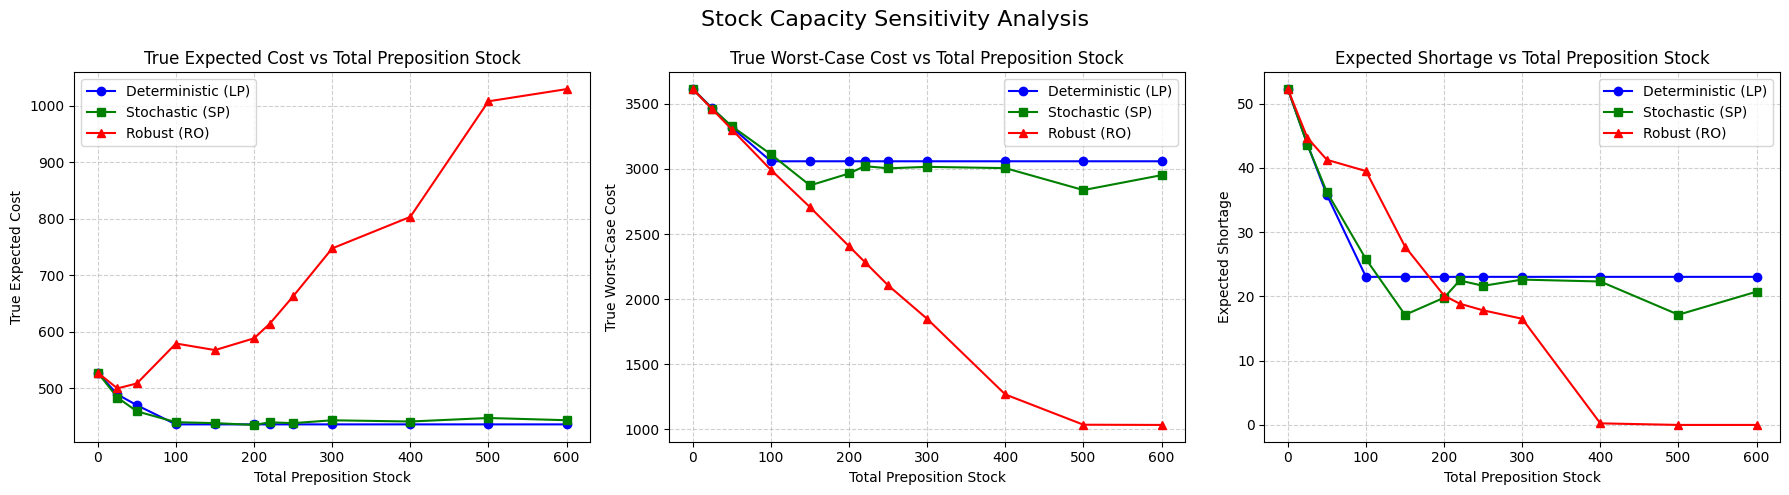

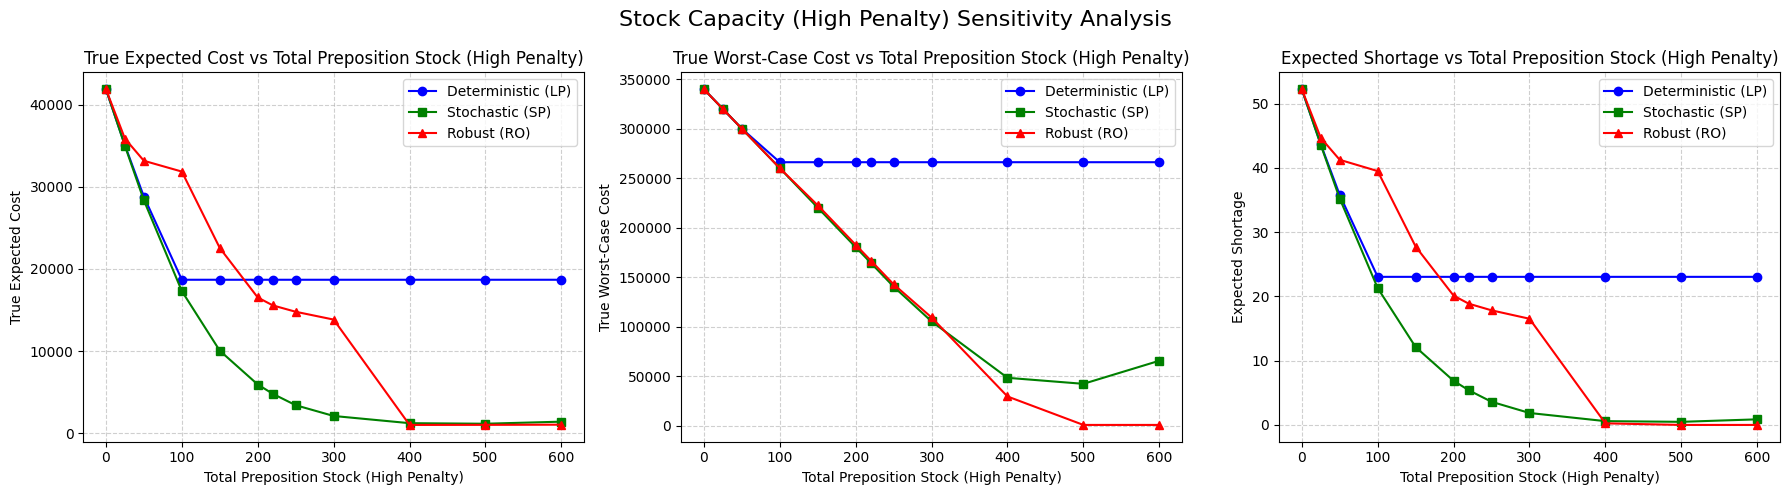

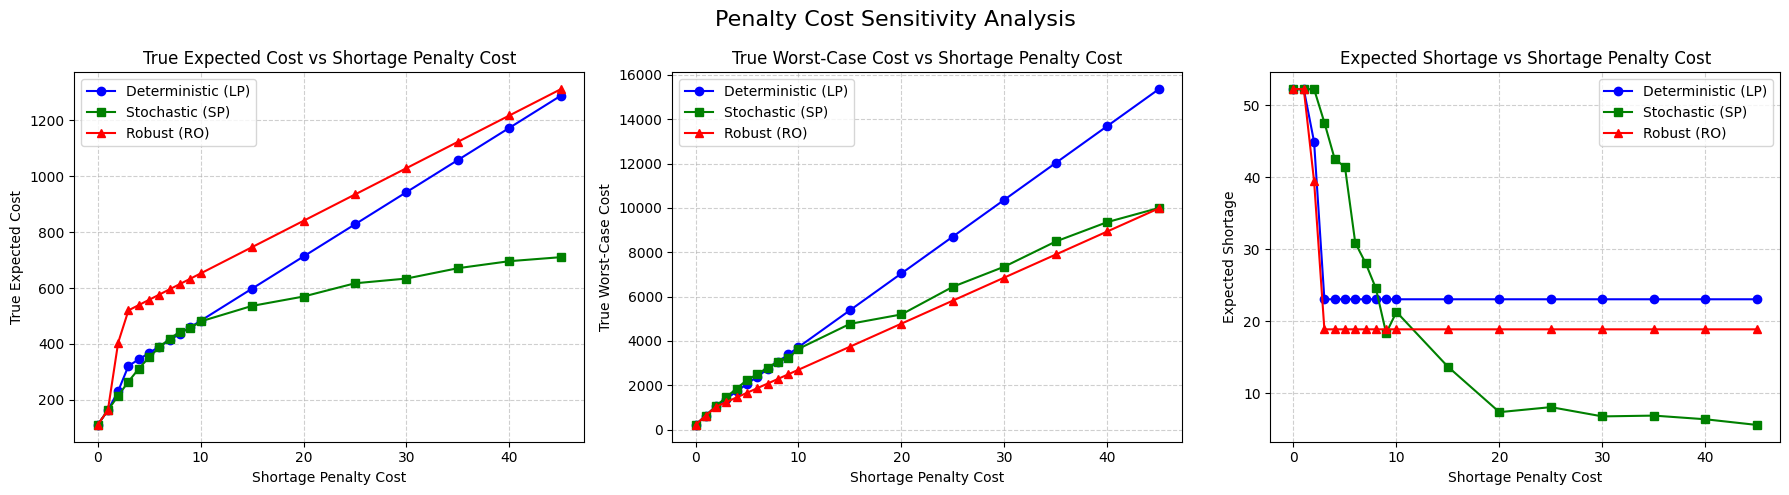

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# ==========================================
# Load Data
# ==========================================
print("Loading Data...")
df_continuous = pd.read_csv("hospital_disaster_continuous_dataset.csv")
df_uncertainty = pd.read_csv("hospital_uncertainty_sets.csv")

full_demand = df_continuous.pivot(index="scenario_id", columns="hospital_id", values="demand")
scenario_probs = df_continuous.groupby("scenario_id")["scenario_probability"].first()
scenario_probs = scenario_probs / scenario_probs.sum()

hospital_info = df_continuous.drop_duplicates(subset=["hospital_id"]).set_index("hospital_id")
hospitals = list(hospital_info.index)
capacity = hospital_info["capacity_beds"].to_dict()
alloc_cost = hospital_info["allocation_cost_per_unit"].to_dict()
surge_capacity = {h: int(capacity[h] * 0.15) for h in hospitals}
surge_cost = hospital_info["surge_cost_per_unit"].to_dict()

# Base Parameters
BASE_PENALTY = max(alloc_cost.values()) * 100  # Default high penalty
BASE_STOCK = 220

# Pre-calculate weighted mean demand for LP
weighted_demand = full_demand.multiply(scenario_probs, axis=0).sum()

# Pre-calculate Worst Case Demand for RO (MinMax Box, Level 1.0)
ro_params = df_uncertainty[
    (df_uncertainty["uncertainty_type"] == "minmax_box") & 
    (df_uncertainty["level"] == 1.0)
].set_index("hospital_id")
worst_case_demand = ro_params["upper_bound"].to_dict()

print("Data Loaded.")

# ==========================================
# Evaluation Function
# ==========================================
def evaluate_plan(plan_x, current_penalty):
    """
    evaluate the allocation plan `plan_x` under the true distribution with given `current_penalty`
    """
    stage1_cost = sum(alloc_cost[h] * plan_x[h] for h in hospitals)
    
    expected_recourse_cost = 0
    worst_case_cost = -1
    total_shortage_weighted = 0
    
    for s in full_demand.index:
        prob = scenario_probs[s]
        recourse_cost_s = 0
        shortage_s = 0
        
        for h in hospitals:
            d = full_demand.loc[s, h]
            remaining = max(0, d - plan_x[h])
            used_surge = min(remaining, surge_capacity[h])
            real_shortage = remaining - used_surge
            
            recourse_cost_s += (used_surge * surge_cost[h]) + (real_shortage * current_penalty)
            shortage_s += real_shortage
        
        total_s_cost = stage1_cost + recourse_cost_s
        expected_recourse_cost += prob * recourse_cost_s
        total_shortage_weighted += prob * shortage_s
        worst_case_cost = max(worst_case_cost, total_s_cost)

    return {
        "True Expected Cost": stage1_cost + expected_recourse_cost,
        "True Worst-Case Cost": worst_case_cost,
        "Expected Shortage": total_shortage_weighted
    }

# ==========================================
# Solvers
# ==========================================

def solve_lp(stock_limit, penalty_cost): # LP
    m = gp.Model("LP")
    m.Params.OutputFlag = 0
    x = m.addVars(hospitals, lb=0, name="x")
    y = m.addVars(hospitals, lb=0, name="y")
    z = m.addVars(hospitals, lb=0, name="z")

    m.addConstr(x.sum() <= stock_limit)
    for h in hospitals:
        m.addConstr(x[h] <= capacity[h])
        m.addConstr(y[h] <= surge_capacity[h])
        m.addConstr(x[h] + y[h] + z[h] >= weighted_demand[h])

    m.setObjective(
        gp.quicksum(alloc_cost[h]*x[h] + surge_cost[h]*y[h] + penalty_cost*z[h] for h in hospitals), 
        GRB.MINIMIZE
    )
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return {h: x[h].X for h in hospitals}
    return {h: 0 for h in hospitals} 

def solve_ro(stock_limit, penalty_cost): # RO
    m = gp.Model("RO")
    m.Params.OutputFlag = 0
    x = m.addVars(hospitals, lb=0, name="x")
    y = m.addVars(hospitals, lb=0, name="y")
    z = m.addVars(hospitals, lb=0, name="z")

    m.addConstr(x.sum() <= stock_limit)
    for h in hospitals:
        m.addConstr(x[h] <= capacity[h])
        m.addConstr(y[h] <= surge_capacity[h])
        m.addConstr(x[h] + y[h] + z[h] >= worst_case_demand[h])

    m.setObjective(
        gp.quicksum(alloc_cost[h]*x[h] + surge_cost[h]*y[h] + penalty_cost*z[h] for h in hospitals), 
        GRB.MINIMIZE
    )
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return {h: x[h].X for h in hospitals}
    return {h: 0 for h in hospitals}

def solve_sp_averaged(stock_limit, penalty_cost, n_samples=50, n_runs=5): # SP (as the sampling might be quite random we do multiple runs and average)
    metrics_sum = {"True Expected Cost": 0, "True Worst-Case Cost": 0, "Expected Shortage": 0}
    
    for i in range(n_runs):
        sampled_scenario_ids = np.random.choice(
            list(full_demand.index), 
            size=n_samples, 
            replace=True, 
            p=scenario_probs.values
        )

        # create indices for sampled scenarios
        sampled_indices = range(SAMPLE_SIZE)
        saa_prob = 1.0 / SAMPLE_SIZE 

        # create sample demand dataframe
        sample_demand = full_demand.loc[sampled_scenario_ids].reset_index(drop=True)
        sample_demand.index = sampled_indices 

        sp_model = gp.Model("SP_Sampling"); sp_model.Params.OutputFlag = 0
        x_sp = sp_model.addVars(hospitals, name="alloc", lb=0)
        y_sp = sp_model.addVars(sampled_indices, hospitals, name="surge", lb=0)
        z_sp = sp_model.addVars(sampled_indices, hospitals, name="shortage", lb=0)

        sp_model.addConstr(gp.quicksum(x_sp[h] for h in hospitals) <= stock_limit)
        for h in hospitals: sp_model.addConstr(x_sp[h] <= capacity[h])

        for s_idx in sampled_indices:
            for h in hospitals:
                sp_model.addConstr(y_sp[s_idx, h] <= surge_capacity[h])
                sp_model.addConstr(x_sp[h] + y_sp[s_idx, h] + z_sp[s_idx, h] >= sample_demand.loc[s_idx, h])
                
        obj_stage1 = gp.quicksum(alloc_cost[h] * x_sp[h] for h in hospitals)
        obj_stage2 = gp.quicksum(saa_prob * gp.quicksum(surge_cost[h] * y_sp[s_idx, h] + penalty_cost * z_sp[s_idx, h] for h in hospitals) for s_idx in sampled_indices)

        sp_model.setObjective(obj_stage1 + obj_stage2, GRB.MINIMIZE)
        sp_model.optimize()
        
        if sp_model.Status == GRB.OPTIMAL:
            plan = {h: x_sp[h].X for h in hospitals}
            # Evaluate IMMEDIATELY with the current penalty
            res = evaluate_plan(plan, penalty_cost)
            for k in metrics_sum:
                metrics_sum[k] += res[k]
    
    # Average the metrics
    return {k: v / n_runs for k, v in metrics_sum.items()}

# ==========================================
# Sensitivity Analysis Increasing Stock Levels
# ==========================================
print("\n--- Experiment A: Increasing Total Stock ---")
stock_levels = [0, 25, 50, 100, 150, 200, 220, 250, 300, 400, 500, 600]
results_stock = {"LP": [], "SP": [], "RO": []}

for stock in stock_levels:
    print(f"  Processing Stock (low panalty) = {stock}...")
    
    # LP
    plan_lp = solve_lp(stock, 8)
    results_stock["LP"].append(evaluate_plan(plan_lp, 8))
    
    # RO
    plan_ro = solve_ro(stock, 8)
    results_stock["RO"].append(evaluate_plan(plan_ro, 8))
    
    # SP (Averaged)
    metrics_sp = solve_sp_averaged(stock, 8)
    results_stock["SP"].append(metrics_sp) # SP returns metrics directly

results_stock_high_penalty = {"LP": [], "SP": [], "RO": []}
for stock in stock_levels:
    print(f"  Processing Stock = {stock}...")
    
    # LP
    plan_lp = solve_lp(stock, 800)
    results_stock_high_penalty["LP"].append(evaluate_plan(plan_lp, 800))
    
    # RO
    plan_ro = solve_ro(stock, 800)
    results_stock_high_penalty["RO"].append(evaluate_plan(plan_ro, 800))
    
    # SP (Averaged)
    metrics_sp = solve_sp_averaged(stock, 800)
    results_stock_high_penalty["SP"].append(metrics_sp) # SP returns metrics directly
# ==========================================
#  Penalty Sensitivity Analysis (Increasing Penalty)
# ==========================================
print("\n--- Experiment B: Increasing Shortage Penalty ---")
penalty_levels = [0,1,2,3,4, 5,6,7,8,9, 10,15,20,25,30,35,40,45]
results_penalty = {"LP": [], "SP": [], "RO": []}

for penalty in penalty_levels:
    print(f"  Processing Penalty = {penalty}...")
    
    # LP
    plan_lp = solve_lp(BASE_STOCK, penalty)
    results_penalty["LP"].append(evaluate_plan(plan_lp, penalty))
    
    # RO
    plan_ro = solve_ro(BASE_STOCK, penalty)
    results_penalty["RO"].append(evaluate_plan(plan_ro, penalty))
    
    # SP (Averaged)
    metrics_sp = solve_sp_averaged(BASE_STOCK, penalty)
    results_penalty["SP"].append(metrics_sp)

# ==========================================
# Plot
# ==========================================
def plot_sensitivity(x_values, res_dict, x_label, title_prefix):
    metrics = ["True Expected Cost", "True Worst-Case Cost", "Expected Shortage"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Extract y values for each model
        y_lp = [r[metric] for r in res_dict["LP"]]
        y_sp = [r[metric] for r in res_dict["SP"]]
        y_ro = [r[metric] for r in res_dict["RO"]]

        
        ax.plot(x_values, y_lp, 'o-', label="Deterministic (LP)", color='blue')
        ax.plot(x_values, y_sp, 's-', label="Stochastic (SP)", color='green')
        ax.plot(x_values, y_ro, '^-', label="Robust (RO)", color='red')
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} vs {x_label}")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

    plt.suptitle(f"{title_prefix} Sensitivity Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nPlotting Results...")
plot_sensitivity(stock_levels, results_stock, "Total Preposition Stock", "Stock Capacity")
plot_sensitivity(stock_levels, results_stock_high_penalty, "Total Preposition Stock (High Penalty)", "Stock Capacity (High Penalty)")
plot_sensitivity(penalty_levels, results_penalty, "Shortage Penalty Cost", "Penalty Cost")


# Sensitivity analyze of increasing Shortage Penalty, and Total capacity (FOR SP, RO different uncertainty set)

Data Loaded.
SP + 4 ROs
  Processing Stock = 0...
  Processing Stock = 50...
  Processing Stock = 100...
  Processing Stock = 150...
  Processing Stock = 200...
  Processing Stock = 220...
  Processing Stock = 250...
  Processing Stock = 300...
  Processing Stock = 400...
  Processing Stock = 500...
  Processing Stock = 600...

Plotting Results...


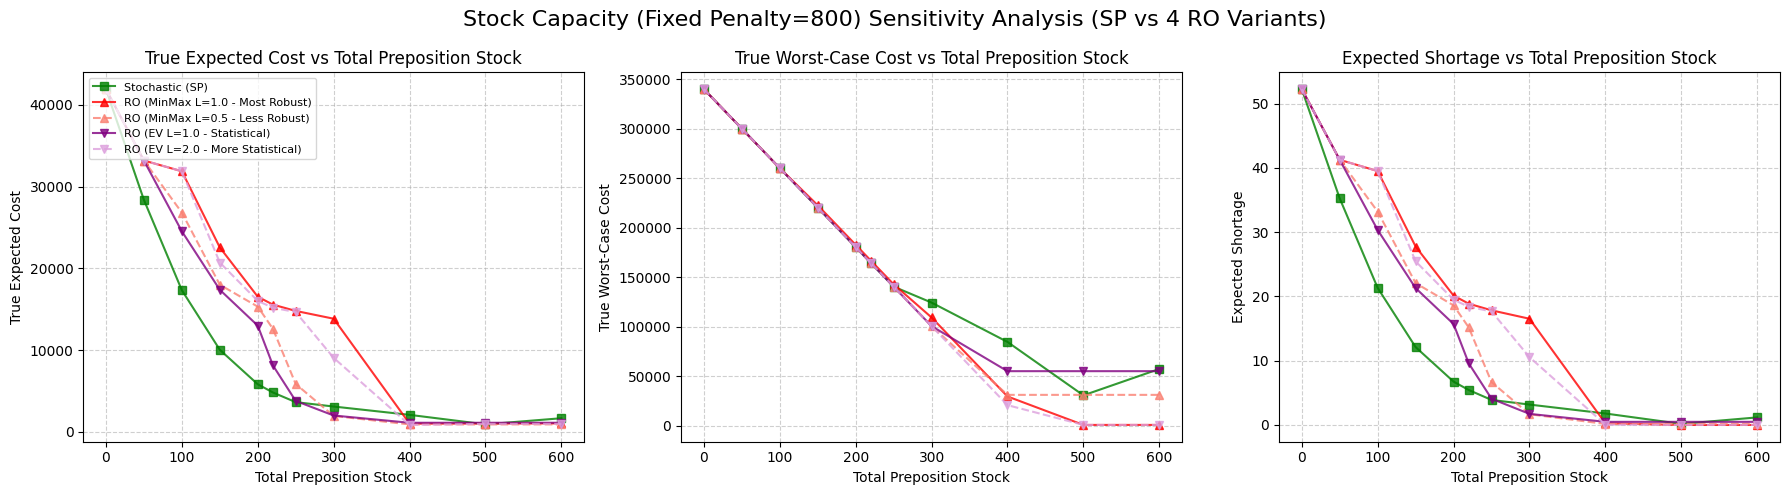

In [6]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# ==========================================
# Load Data
# ==========================================
df_continuous = pd.read_csv("hospital_disaster_continuous_dataset.csv")
df_uncertainty = pd.read_csv("hospital_uncertainty_sets.csv")

# Data Processing
full_demand = df_continuous.pivot(index="scenario_id", columns="hospital_id", values="demand")
scenario_probs = df_continuous.groupby("scenario_id")["scenario_probability"].first()
scenario_probs = scenario_probs / scenario_probs.sum()

# Parameters
hospital_info = df_continuous.drop_duplicates(subset=["hospital_id"]).set_index("hospital_id")
hospitals = list(hospital_info.index)
capacity = hospital_info["capacity_beds"].to_dict()
alloc_cost = hospital_info["allocation_cost_per_unit"].to_dict()
surge_capacity = {h: int(capacity[h] * 0.15) for h in hospitals}
surge_cost = hospital_info["surge_cost_per_unit"].to_dict()

# Base Parameters
BASE_PENALTY = 800
BASE_STOCK = 220 

# Pre-calculations
weighted_demand = full_demand.multiply(scenario_probs, axis=0).sum()
ro_params_mm_1_0 = df_uncertainty[(df_uncertainty["uncertainty_type"] == "minmax_box") & (df_uncertainty["level"] == 1.0)].set_index("hospital_id")
worst_case_demand_mm_1_0 = ro_params_mm_1_0["upper_bound"].to_dict()

print("Data Loaded.")

# ==========================================
# 2. evaluation function
# ==========================================
def evaluate_plan(plan_x, current_penalty):
    stage1_cost = sum(alloc_cost[h] * plan_x[h] for h in hospitals)
    expected_recourse = 0
    worst_case = -1
    total_shortage = 0
    
    for s in full_demand.index:
        prob = scenario_probs[s]; s_recourse = 0; s_shortage = 0
        for h in hospitals:
            d = full_demand.loc[s, h]
            rem = max(0, d - plan_x[h])
            use_surge = min(rem, surge_capacity[h])
            real_short = rem - use_surge
            s_recourse += (use_surge * surge_cost[h]) + (real_short * current_penalty)
            s_shortage += real_short
        
        total_s_cost = stage1_cost + s_recourse
        expected_recourse += prob * s_recourse
        total_shortage += prob * s_shortage
        worst_case = max(worst_case, total_s_cost)

    return {
        "True Expected Cost": stage1_cost + expected_recourse,
        "True Worst-Case Cost": worst_case,
        "Expected Shortage": total_shortage
    }

def solve_ro(stock_limit, penalty_cost, ro_demand_bounds):
    # RO Solver needs dynamic bounds input
    m = gp.Model("RO"); m.Params.OutputFlag = 0
    x = m.addVars(hospitals, lb=0); y = m.addVars(hospitals, lb=0); z = m.addVars(hospitals, lb=0)
    m.addConstr(x.sum() <= stock_limit)
    for h in hospitals:
        m.addConstr(x[h] <= capacity[h]); m.addConstr(y[h] <= surge_capacity[h])
        m.addConstr(x[h] + y[h] + z[h] >= ro_demand_bounds[h])
    m.setObjective(gp.quicksum(alloc_cost[h]*x[h] + surge_cost[h]*y[h] + penalty_cost*z[h] for h in hospitals), GRB.MINIMIZE)
    m.optimize()
    return {h: x[h].X for h in hospitals} if m.Status == GRB.OPTIMAL else {h: 0 for h in hospitals}

def solve_sp_averaged(stock_limit, penalty_cost, n_samples=50, n_runs=5):
    metrics_sum = {"True Expected Cost": 0, "True Worst-Case Cost": 0, "Expected Shortage": 0}
    for i in range(n_runs):
        sampled_scenario_ids = np.random.choice(
            list(full_demand.index), 
            size=n_samples, 
            replace=True,
            p=scenario_probs.values
        )

        sampled_indices = range(SAMPLE_SIZE)
        saa_prob = 1.0 / SAMPLE_SIZE 
        sample_demand = full_demand.loc[sampled_scenario_ids].reset_index(drop=True)
        sample_demand.index = sampled_indices 

        sp_model = gp.Model("SP_Sampling"); sp_model.Params.OutputFlag = 0
        x_sp = sp_model.addVars(hospitals, name="alloc", lb=0)
        y_sp = sp_model.addVars(sampled_indices, hospitals, name="surge", lb=0)
        z_sp = sp_model.addVars(sampled_indices, hospitals, name="shortage", lb=0)

        sp_model.addConstr(gp.quicksum(x_sp[h] for h in hospitals) <= stock_limit)
        for h in hospitals: sp_model.addConstr(x_sp[h] <= capacity[h])

        for s_idx in sampled_indices: # repeat using the index to samped demand
            for h in hospitals:
                sp_model.addConstr(y_sp[s_idx, h] <= surge_capacity[h])
                sp_model.addConstr(x_sp[h] + y_sp[s_idx, h] + z_sp[s_idx, h] >= sample_demand.loc[s_idx, h])
                
        obj_stage1 = gp.quicksum(alloc_cost[h] * x_sp[h] for h in hospitals)
        obj_stage2 = gp.quicksum(saa_prob * gp.quicksum(surge_cost[h] * y_sp[s_idx, h] + penalty_cost * z_sp[s_idx, h] for h in hospitals) for s_idx in sampled_indices)

        sp_model.setObjective(obj_stage1 + obj_stage2, GRB.MINIMIZE)
        sp_model.optimize()

        if sp_model.Status == GRB.OPTIMAL:
            plan = {h: x_sp[h].X for h in hospitals}
            res = evaluate_plan(plan, penalty_cost)
            for k in metrics_sum: metrics_sum[k] += res[k]
    return {k: v / n_runs for k, v in metrics_sum.items()}

# ==========================================
# 5 model s Sensitivity Analysis
# ==========================================
print("SP + 4 ROs")
stock_levels = [0, 50, 100, 150, 200, 220, 250, 300, 400, 500, 600]
PENALTY_TEST = 800 # Fixed High Penalty

# Denaming RO bounds for different configurations
ro_bounds = {}
ro_configs_to_test = [
    ("minmax_box", 1.0), ("minmax_box", 0.5), 
    ("ev_box", 1.0), ("ev_box", 2.0)
]
for u_type, u_level in ro_configs_to_test:
    key = f"RO_{u_type}_{u_level}"
    ro_bounds[key] = df_uncertainty[
        (df_uncertainty["uncertainty_type"] == u_type) & 
        (df_uncertainty["level"] == u_level)
    ].set_index("hospital_id")["upper_bound"].to_dict()

# initialize results storage
results_5lines = {
    "SP": [], 
    "RO_mm_1_0": [], "RO_mm_0_5": [], 
    "RO_ev_1_0": [], "RO_ev_2_0": []
}

for stock in stock_levels:
    print(f"  Processing Stock = {stock}...")
    
    # SP (Averaged)
    results_5lines["SP"].append(solve_sp_averaged(stock, PENALTY_TEST))
    
    # ROs
    results_5lines["RO_mm_1_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_minmax_box_1.0"]), PENALTY_TEST))
    results_5lines["RO_mm_0_5"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_minmax_box_0.5"]), PENALTY_TEST))
    results_5lines["RO_ev_1_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_ev_box_1.0"]), PENALTY_TEST))
    results_5lines["RO_ev_2_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_ev_box_2.0"]), PENALTY_TEST))

# ==========================================
# Plot (5 lines)
# ==========================================
def plot_5lines_sensitivity(x_values, res_dict, x_label, title_prefix):
    metrics = ["True Expected Cost", "True Worst-Case Cost", "Expected Shortage"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    line_styles = {
        "SP": ('s-', 'green'), 
        "RO_mm_1_0": ('^-', 'red'), "RO_mm_0_5": ('^--', 'salmon'),
        "RO_ev_1_0": ('v-', 'purple'), "RO_ev_2_0": ('v--', 'plum')
    }
    
    legend_names = {
        "SP": "Stochastic (SP)", 
        "RO_mm_1_0": "RO (MinMax L=1.0 - Most Robust)", 
        "RO_mm_0_5": "RO (MinMax L=0.5 - Less Robust)",
        "RO_ev_1_0": "RO (EV L=1.0 - Statistical)",
        "RO_ev_2_0": "RO (EV L=2.0 - More Statistical)"
    }

    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        for key, (marker, color) in line_styles.items():
            y_data = [r[metric] for r in res_dict[key]]
            ax.plot(x_values, y_data, marker, label=legend_names[key], color=color, alpha=0.8)
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} vs {x_label}")
        ax.grid(True, linestyle='--', alpha=0.6)
        if i == 0:
            ax.legend(loc='upper left', fontsize=8)

    plt.suptitle(f"{title_prefix} Sensitivity Analysis (SP vs 4 RO Variants)", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nPlotting Results...")
plot_5lines_sensitivity(stock_levels, results_5lines, "Total Preposition Stock", f"Stock Capacity (Fixed Penalty={PENALTY_TEST})")

  Processing Stock = 0...
  Processing Stock = 50...
  Processing Stock = 100...
  Processing Stock = 150...
  Processing Stock = 200...
  Processing Stock = 220...
  Processing Stock = 250...
  Processing Stock = 300...
  Processing Stock = 400...
  Processing Stock = 500...
  Processing Stock = 600...

Plotting Results...


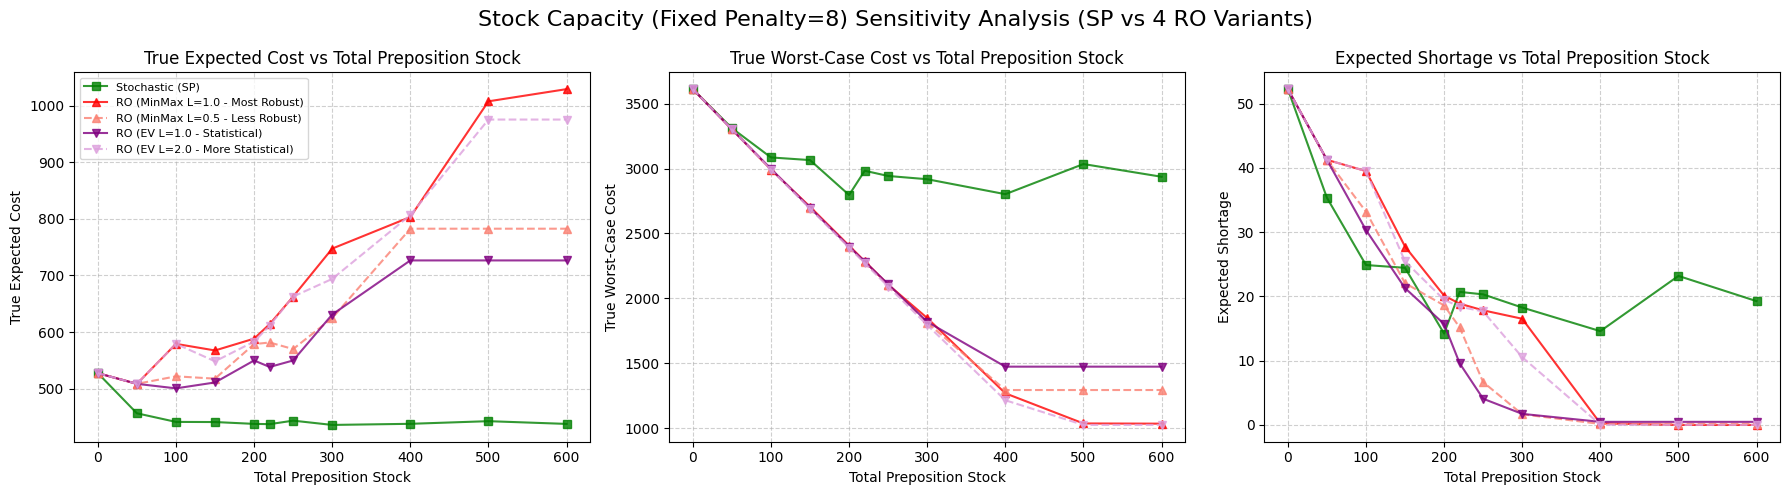

In [ ]:
# SP + 4RP low penalty
PENALTY_TEST = 8

# initialize results storage
results_5lines = {
    "SP": [], 
    "RO_mm_1_0": [], "RO_mm_0_5": [], 
    "RO_ev_1_0": [], "RO_ev_2_0": []
}

for stock in stock_levels:
    print(f"  Processing Stock = {stock}...")
    
    # SP (Averaged)
    results_5lines["SP"].append(solve_sp_averaged(stock, PENALTY_TEST))
    
    # ROs
    results_5lines["RO_mm_1_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_minmax_box_1.0"]), PENALTY_TEST))
    results_5lines["RO_mm_0_5"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_minmax_box_0.5"]), PENALTY_TEST))
    results_5lines["RO_ev_1_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_ev_box_1.0"]), PENALTY_TEST))
    results_5lines["RO_ev_2_0"].append(evaluate_plan(solve_ro(stock, PENALTY_TEST, ro_bounds["RO_ev_box_2.0"]), PENALTY_TEST))


print("\nPlotting Results...")
plot_5lines_sensitivity(stock_levels, results_5lines, "Total Preposition Stock", f"Stock Capacity (Fixed Penalty={PENALTY_TEST})")